# Write A Fxn to Turn PLY into GIF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import open3d as o3d
import matplotlib.image as mpimg
import cv2 as cv

In [2]:
# these functions are to preprocess the data

def reject_outliers(data, m=1):
    return abs(data - np.mean(data)) < m * np.std(data)

def inter_ply(filename):
    
    # load set to df
    attr = ['x','y', 'z', 'nx','ny', 'nz', 'diffuse_red', 'diffuse_green', 'diffuse_blue', 'class', 'detection']
    pd1 = np.loadtxt(filename, delimiter=" ", skiprows=15)
    df = pd.DataFrame(pd1)
    
    df.columns = attr

    # def a thresh for the points
    ythresh = np.median(df['y']) + np.std(df['y'])
    
    mask = reject_outliers(df['x']) & reject_outliers(df['z'])
    df1 = df.loc[mask]
    df1 = df1.loc[df1['y'] < ythresh]
    
    print(f"pts gen: {len(df1)}")
    
    return df1
    

In [3]:
# write all relevant pts to new ply
def write_ply(filename, df):
    header = f'''ply 
    format ascii 1.0
    element vertex {len(df)}
    property float x
    property float y
    property float z
    property float nx
    property float ny
    property float nz
    property uchar diffuse_red
    property uchar diffuse_green
    property uchar diffuse_blue
    property uchar class
    property uchar detection
    end_header
    '''
    with open(filename, "w+") as p:
        p.write(header)
        for i in df.iterrows():
            p.write(f"{i[1]['x']} {i[1]['y']} \
                    {i[1]['z']} {i[1]['nx']} \
                    {i[1]['ny']} {i[1]['nz']} \
                    {int(i[1]['diffuse_red'])} \
                    {int(i[1]['diffuse_green'])} \
                    {int(i[1]['diffuse_blue'])} \
                    {int(i[1]['class'])} \
                    {int(i[1]['detection'])} \n")

In [4]:
# find bounding box
def transform_pts(df, overlay_pic):
    img = mpimg.imread(overlay_pic)
    w,h = img.shape[1], img.shape[0]
    print(f"size {w}, {h} picture")
    
    x_min, x_max = min(df['x']), max(df['x'])
    z_min, z_max = min(df['z']), max(df['z'])
    print(f"x scale range {x_min}, {x_max}, {x_max-x_min}, to {w}")
    print(f"z scale range {z_min}, {z_max}, {z_max-z_min}, to {h}")

    x_trans = np.interp(df['x'], (x_min, x_max), (0, w-1))
    y_trans = -1 * np.interp(df['z'], (z_min, z_max), (0, h-1)) + h
    
    return x_trans, y_trans, img

In [10]:
# double pass on grabcut to get foreground mask
def grab_cut_mask(filename, x, y):
    img = cv.imread(filename)
    
    # empty vals that opencv will populate
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    
    x_sample, y_sample = np.random.choice(x, size=len(x)//2), np.random.choice(y, size=len(y)//2)
    
    corner1_X, corner1_Y = int(min(x_sample)), int(min(y_sample))
    corner2_X, corner2_Y = int(max(x_sample)), int(max(y_sample))
    
    rect = (corner1_X, corner1_Y, corner2_X, corner2_Y)
    
    cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)
    
    return img, mask, bgdModel, fgdModel
        

In [13]:
def generate_mask(ply, new_ply, underlay_img):
    print("start")
    df = inter_ply(ply)
    print("new_ply")
    write_ply(new_ply, df)
    print("Trans pts")
    x, y, img = transform_pts(df, underlay_img)
    print("grabcut")
    img1, mask, bmodel, fmodel = grab_cut_mask(underlay_img, x, y)
    
    return img1, mask, bmodel, fmodel

In [49]:
def show_mask(img, m):
    f = np.where(((m==2) | (m==0)),0,1).astype('uint8')
    img[:,:,[0,2]] = img[:,:,[2,0]]
    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    ax[0].imshow(img)
    ax[0].set_title("OG IMG")
    ax[1].imshow(img * f[:,:,np.newaxis])
    ax[1].set_title("Predicted Foreground")

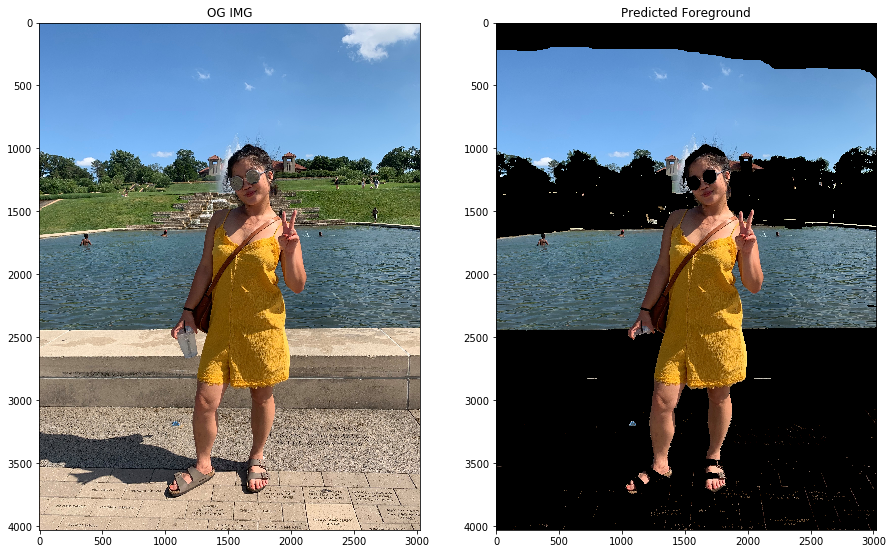

In [51]:
i, m, b, f = generate_mask("ply/tuby.ply", "ply/just_tuby.ply", "imgs/tuby.jpg")
show_mask(i, m)

start
pts gen: 136071
new_ply
Trans pts
size 3024, 4032 picture
x scale range -0.689, 1.061, 1.75, to 3024
z scale range -1.2324, 0.6521, 1.8845, to 4032
grabcut


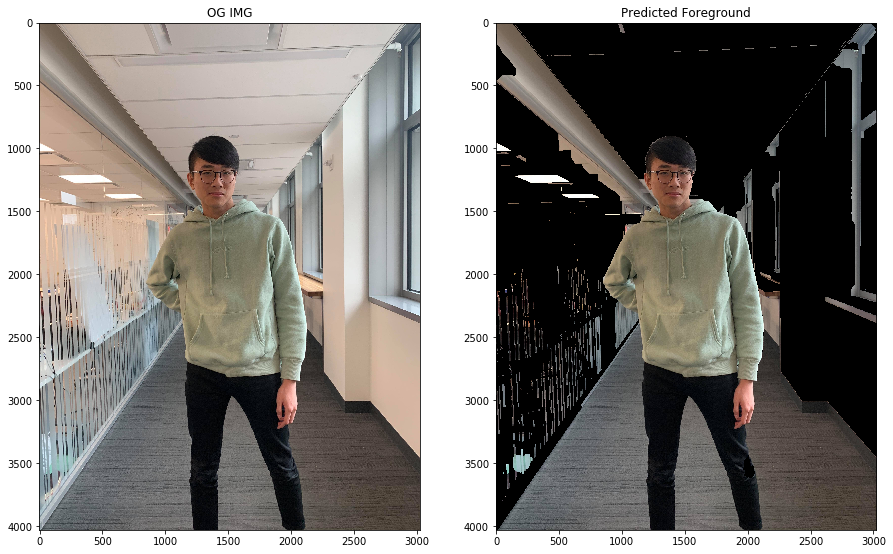

In [52]:
i, m, b, f = generate_mask("ply/roy.ply", "ply/just_roy.ply", "imgs/roy.jpg")
show_mask(i, m)

start
pts gen: 40038
new_ply
Trans pts
size 4032, 3024 picture
x scale range -1.7257, 1.1081, 2.8338, to 4032
z scale range -1.1881, 0.1926, 1.3807, to 3024
grabcut


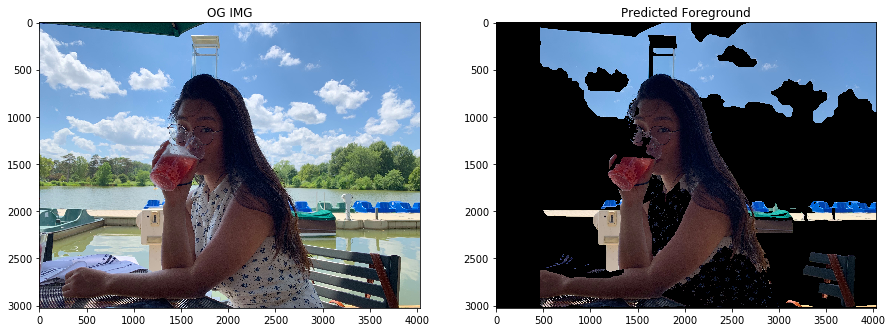

In [53]:
i, m, b, f = generate_mask("ply/drink.ply", "ply/just_drink.ply", "imgs/drink.jpg",)
show_mask(i, m)

# Past here is not for Intro ML
## But feel free to look, gen examples

In [ ]:
def do_it_all(ply, new_ply, underlay_img, output_loc, gif_name):
    print("start")
    df = inter_ply(ply)
    print("new_ply")
    write_ply(new_ply, df)
    print("Trans pts")
    x, y, img = transform_pts(df, underlay_img)
    print("grabcut")
    img1, mask, bmodel, fmodel = grab_cut_mask(underlay_img, x, y)
    print("mm")
    rough_mura_masa(img1, mask, output_loc)
#     return img1, mask, bmodel, fmodel 
    print("gen_gif")
    gen_gif(output_loc, gif_name)
#     HTML(f'<img width=300px src="{output_loc}/{gif_name}.gif">')

def rough_mura_masa(img, mask, output_loc):
    
    bk_mask = np.where((mask==3),0,1).astype('uint8')
    fg_mask = np.where(((mask==2) | (mask==0)),0,1).astype('uint8')
    
    fg_pxs = img * fg_mask[:,:,np.newaxis]
    bg_pxs = img * bk_mask[:,:,np.newaxis]

    for i in range(-10, 10):
        n = 5 * i
        move_n_x = np.roll(fg_pxs, shift=n, axis=1)
        new_img = np.where(move_n_x == 0, bg_pxs, move_n_x)
        cv.imwrite(f"{output_loc}/img{i+10:02d}.jpg", new_img)
        
def gen_gif(img_path, gif_name, keep_mp4=False):
    mp4_gen = f'ffmpeg -r 5 -i {img_path}/img%02d.jpg {img_path}/test.mp4'
    pingpong_gen = f'ffmpeg -i {img_path}/test.mp4 -filter_complex "[0]reverse[r];[0][r]concat,loop=5:250,setpts=N/25/TB" {img_path}/output.mp4'
    gif_gen = f'ffmpeg -i {img_path}/output.mp4 -f gif {img_path}/{gif_name}.gif'
    output = f'rm {img_path}/output.mp4'
    !{output}
    !{mp4_gen}
    !{pingpong_gen}
    !{gif_gen}
    
    if not keep_mp4:
        rm_mp4 = f'rm {img_path}/test.mp4'
        !{rm_mp4}

In [ ]:
# do_it_all("ply/tuby.ply", "ply/just_tuby.ply", "imgs/tuby.jpg","grabcut_res", "tuby")
HTML(f'<img width=300px src="grabcut_res/tuby.gif">')

In [ ]:
# do_it_all("ply/roy.ply", "ply/just_roy.ply", "imgs/roy.jpg","grabcut_res/roy", "roy")
HTML(f'<img width=300px src="grabcut_res/roy/roy.gif">')

In [ ]:
# do_it_all("ply/kent.ply", "ply/just_kent.ply", "imgs/kent.jpg","grabcut_res/kent", "kent")
HTML(f'<img width=300px src="grabcut_res/kent/kent.gif">')

In [ ]:
# do_it_all("ply/drink.ply", "ply/just_drink.ply", "imgs/drink.jpg","grabcut_res/drink", "drink")
HTML(f'<img width=300px src="grabcut_res/drink/drink.gif">')

# let inpaint some pics, maybe itll be better

In [ ]:
bk_mask = np.where((mask==3),0,1).astype('uint8')
fg_mask = np.where(((mask==2) | (mask==0)),0,1).astype('uint8')

fg_pxs = img * fg_mask[:,:,np.newaxis]
bg_pxs = img * bk_mask[:,:,np.newaxis]

plt.imshow(bg_pxs)

In [19]:
img1, mask, bmodel, fmodel = do_it_all("ply/amanda.ply", "ply/just_amanda.ply", "imgs/amanda.jpg","grabcut_res/amanda", "amanda")
bk_mask = np.where((mask==3),0,1).astype('uint8')

pts gen: 54584
size 3024, 4032 picture
x scale range -1.887, 0.4753, 2.3623, to 3024
z scale range -5.0727, -2.9102, 2.1625, to 4032


In [30]:
fg_mask = np.where(((mask==2) | (mask==0)),0,1).astype('uint8')
dst = cv.inpaint(img1,fg_mask,3,cv.INPAINT_NS )

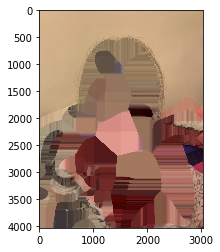

In [33]:
plt.imshow(np.flip(dst,axis=2))

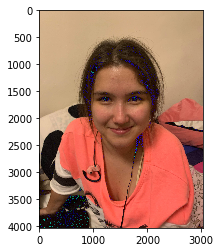

In [29]:
n = 5
fg_pxs = img1 * fg_mask[:,:,np.newaxis]
move_n_x = np.roll(fg_pxs, shift=n, axis=1)
new_img = np.where(move_n_x == 0, dst, move_n_x)
# cv.imwrite(f"{output_loc}/img{i+10:02d}.jpg", new_img)
plt.imshow(np.flip(new_img, axis=2))

# enlarge foreground 

In [31]:
# do_it_all("ply/drink.ply", "ply/just_drink.ply", "imgs/drink.jpg","grabcut_res/drink", "drink")
df = inter_ply("ply/roy.ply")
x, y, img = transform_pts(df, "imgs/roy.jpg")
img1, mask, bmodel, fmodel = grab_cut_mask("imgs/roy.jpg", x, y)

pts gen: 136071
size 3024, 4032 picture
x scale range -0.689, 1.061, 1.75, to 3024
z scale range -1.2324, 0.6521, 1.8845, to 4032


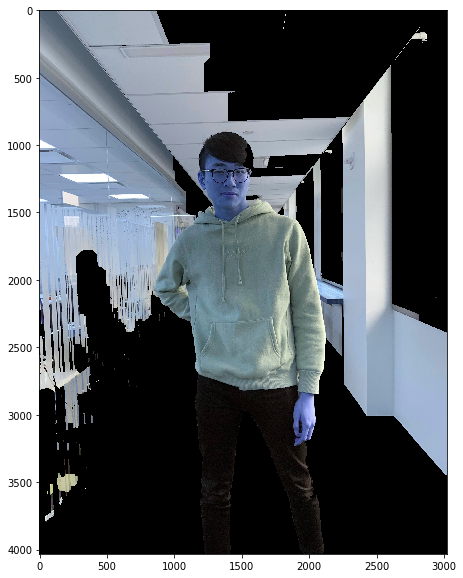

In [63]:
# plt.imshow(mask)
fg_mask = np.where(((mask==2) | (mask==0)),0,1).astype('uint8')
fg_pxs = img1 * fg_mask[:,:,np.newaxis]
plt.figure(figsize=(10,10))
plt.imshow(fg_pxs)

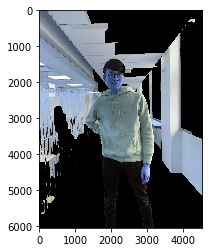

In [64]:
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
w,h = fg_pxs.shape[1], fg_pxs.shape[0]
dim = (int(w*1.5), int(h*1.5))
# resize image
resized = cv.resize(fg_pxs, dim, interpolation = cv.INTER_AREA)
plt.imshow(resized)

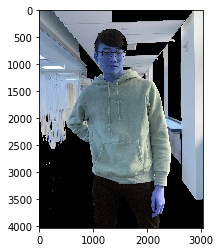

In [65]:
# crop the resize

# middle of the picture, add the w and h on both sizes

rw, rh = resized.shape[1], resized.shape[0]
c1, c2= (rw//2 - w//2, rw//2 + w//2), (rh//2 - h//2, rh//2 + h//2)
cropped = resized[c2[0]:c2[1],c1[0]:c1[1],:]
plt.imshow(cropped)

In [66]:
cropped.shape

(4032, 3024, 3)

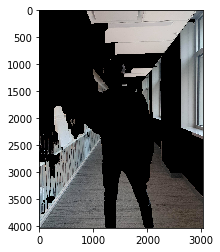

In [67]:
bk_mask = np.where((mask==3),0,1).astype('uint8')
bg_pxs = img * bk_mask[:,:,np.newaxis]
plt.imshow(bg_pxs)

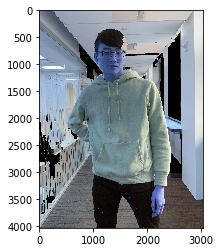

In [68]:
new_img = np.where(cropped == 0, bg_pxs, cropped)
plt.imshow(new_img)

In [76]:
for i in range(-10, 10):
    n = 5 * i
    move_n_x = np.roll(cropped, shift=n, axis=1)
    new_img = np.where(move_n_x == 0, bg_pxs, move_n_x)
    cv.imwrite(f"enlarge/img{i+10:02d}.jpg", new_img)

In [77]:
def gen_gif_1(img_path, gif_name, keep_mp4=False):
    mp4_gen = f'ffmpeg -r 5 -i {img_path}/img%02d.jpg {img_path}/test.mp4'
    pingpong_gen = f'ffmpeg -i {img_path}/test.mp4 -filter_complex "[0]reverse[r];[0][r]concat,loop=5:250,setpts=N/25/TB" {img_path}/output.mp4'
    gif_gen = f'ffmpeg -i {img_path}/output.mp4 -f gif {img_path}/{gif_name}.gif'
#     output = f'rm {img_path}/output.mp4'
#     !{output}
    !{mp4_gen}
    !{pingpong_gen}
    !{gif_gen}
    
    if not keep_mp4:
        rm_mp4 = f'rm {img_path}/test.mp4'
        !{rm_mp4}
        
gen_gif_1('enlarge', "roy", keep_mp4=True)

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

frame=   50 fps=7.6 q=-1.0 Lsize=    3497kB time=00:00:09.40 bitrate=3047.8kbits/s dup=0 drop=190 speed=1.43x    
video:3496kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041540%
[libx264 @ 0x565222bb4100] frame I:1     Avg QP:12.41  size:1530241
[libx264 @ 0x565222bb4100] frame P:13    Avg QP:14.34  size: 49785
[libx264 @ 0x565222bb4100] frame B:36    Avg QP:20.99  size: 38932
[libx264 @ 0x565222bb4100] consecutive B-frames:  4.0%  0.0%  0.0% 96.0%
[libx264 @ 0x565222bb4100] mb I  I16..4:  4.5% 86.0%  9.5%
[libx264 @ 0x565222bb4100] mb P  I16..4:  0.2%  0.5%  0.2%  P16..4: 28.1%  1.0%  1.4%  0.0%  0.0%    skip:68.6%
[libx264 @ 0x565222bb4100] mb B  I16..4:  0.3%  0.7%  0.3%  B16..8: 18.8%  1.3%  0.5%  direct: 0.8%  skip:77.4%  L0:41.4% L1:57.7% BI: 0.9%
[libx264 @ 0x565222bb4100] 8x8 transform intra:74.2% inter:72.0%
[libx264 @ 0x565222bb4100] coded y,uvDC,uvAC intra: 71.4% 38.0% 23.6% inter: 2.2% 3.6% 1.2%
[libx264 @ 0x565222bb4100] i16 v,h,dc,p: 81

In [3]:
HTML(f'<img width=300px src="enlarge/roy.gif">')

In [2]:
from IPython.display import HTML